<a href="https://colab.research.google.com/github/Bosy-Ayman/DSAI-402-RL/blob/main/Assignment4_RL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import itertools


In [17]:
class HanoiEnv(gym.Env):
    def __init__(self, n_disks=3, n_pegs=3):
        super(HanoiEnv, self).__init__()

        self.n_disks = n_disks
        self.n_pegs = n_pegs
        self.observation_space = spaces.MultiDiscrete([n_pegs] * n_disks)

        # 3 pegs → 6 actions
        self.actions = []
        for i in range(n_pegs):
            for j in range(n_pegs):
                if i != j:
                    self.actions.append((i, j))

        self.action_space = spaces.Discrete(len(self.actions))

        self.start_state = tuple([0] * self.n_disks)
        self.goal_state = tuple([self.n_pegs - 1] * self.n_disks)
        self.state = None

    def reset(self, seed=None, options=None):
        self.state = self.start_state
        return np.array(self.state), {}

    def get_top_disk(self, peg):
        for disk in range(self.n_disks):
            if self.state[disk] == peg:
                return disk
        return None

    def is_valid(self, from_peg, to_peg):
        d1 = self.get_top_disk(from_peg)
        d2 = self.get_top_disk(to_peg)
        if d1 is None:
            return False
        if d2 is None:
            return True
        return d1 < d2

    # Convert action index → actual move
    def step(self, action):
        from_peg, to_peg = self.actions[action]

        if self.is_valid(from_peg, to_peg):
            state_list = list(self.state)
            disk = self.get_top_disk(from_peg)
            state_list[disk] = to_peg
            self.state = tuple(state_list)

        reward = -1
        done = (self.state == self.goal_state)
        return np.array(self.state), reward, done, False, {}

    def render(self):
        print(f"State: {self.state}")


# Policy evaluation & improvement functions

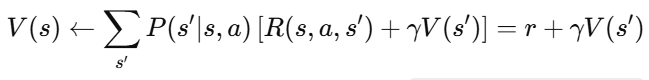

In [18]:
def evaluate_policy(env, policy, V, gamma=0.9, theta=1e-6):
    while True:
        delta = 0
        for s in states:
            if tuple(s) == env.goal_state:
                continue
            v_old = V[tuple(s)]
            a = policy[tuple(s)]
            env.state = tuple(s)
            next_s, r, d, _, _ = env.step(a)
            V[tuple(s)] = r + gamma * V[tuple(next_s)]
            delta = max(delta, abs(v_old - V[tuple(s)]))
        if delta < theta:
            break



### pick the action with the highest value

In [20]:

def improve_policy(env, policy, V, gamma=0.9):
    stable = True
    for s in states:
        if tuple(s) == env.goal_state:
            continue
        old_a = policy[tuple(s)]
        best_value = -1e9
        best_a = 0
        for a in range(env.action_space.n):
            env.state = tuple(s)
            next_s, r, d, _, _ = env.step(a)
            val = r + gamma * V[tuple(next_s)]
            if val > best_value:
                best_value = val
                best_a = a
        policy[tuple(s)] = best_a
        if best_a != old_a:
            stable = False
    return stable

In [23]:
def print_policy(env, policy):
    print("\n Optimal Policy \n")
    sorted_states = sorted(states)

    for s in sorted_states:
        if s == env.goal_state:
            print(f"State {s} (Goal) => Terminal")
            continue

        action = policy[s]
        move = env.actions[action]
        print(f"State {s} -> Move disk from Peg {move[0]} to Peg {move[1]}")


In [24]:
print_policy(env, policy)



--- Optimal Policy (Action to take in each state) ---

State (0, 0, 0) -> Move disk from Peg 0 to Peg 2
State (0, 0, 1) -> Move disk from Peg 1 to Peg 2
State (0, 0, 2) -> Move disk from Peg 0 to Peg 1
State (0, 1, 0) -> Move disk from Peg 0 to Peg 1
State (0, 1, 1) -> Move disk from Peg 0 to Peg 2
State (0, 1, 2) -> Move disk from Peg 1 to Peg 2
State (0, 2, 0) -> Move disk from Peg 2 to Peg 1
State (0, 2, 1) -> Move disk from Peg 0 to Peg 1
State (0, 2, 2) -> Move disk from Peg 0 to Peg 2
State (1, 0, 0) -> Move disk from Peg 1 to Peg 2
State (1, 0, 1) -> Move disk from Peg 1 to Peg 0
State (1, 0, 2) -> Move disk from Peg 0 to Peg 2
State (1, 1, 0) -> Move disk from Peg 0 to Peg 2
State (1, 1, 1) -> Move disk from Peg 1 to Peg 2
State (1, 1, 2) -> Move disk from Peg 1 to Peg 0
State (1, 2, 0) -> Move disk from Peg 1 to Peg 0
State (1, 2, 1) -> Move disk from Peg 2 to Peg 0
State (1, 2, 2) -> Move disk from Peg 1 to Peg 2
State (2, 0, 0) -> Move disk from Peg 0 to Peg 1
State (2, 0, 

In [22]:
env = HanoiEnv(n_disks=3, n_pegs=3)

states = list(itertools.product(range(env.n_pegs), repeat=env.n_disks))
V = {s: 0 for s in states}
policy = {s: env.action_space.sample() for s in states}

iteration = 0
while True:
    iteration += 1
    evaluate_policy(env, policy, V)
    if improve_policy(env, policy, V):
        break

print(f"\nPolicy converged in {iteration} iterations")
print(f"State Value: {V[env.start_state]:.2f}")


Policy converged in 7 iterations
Start State Value: -5.22
